In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#tf.get_logger().setLevel(40) # suppress deprecation messages
#tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import preprocessing

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM


In [2]:
cnn = load_model("mnist_cnn.h5")

In [3]:
ae = load_model("mnist_ae.h5")

In [4]:
test = preprocessing.image_dataset_from_directory("../data/MNIST_V1/test", labels = "inferred", label_mode = "categorical", color_mode = "grayscale", image_size = (28, 28), batch_size = 256)
query = preprocessing.image_dataset_from_directory("../data/MNIST_V1/query", labels = "inferred", label_mode = "categorical", color_mode = "grayscale", image_size = (28, 28), batch_size = 256)


Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [5]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [6]:
prediction = np.array([])
labels = np.array([])
for data, label in test:
    prediction = np.concatenate([prediction, np.argmax(cnn.predict(data), -1)])
    labels = np.concatenate([labels, np.argmax(label.numpy(), axis = -1)])


In [7]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1, 28, 28, 1)  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (0, 1)  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1.

In [14]:
for data, label in test:
    decoded_img = ae.predict(data/255.)
    break

In [15]:
print(data.shape, decoded_img.shape)

(256, 28, 28, 1) (256, 28, 28, 1)


In [16]:
print(type(data))

<class 'tensorflow.python.framework.ops.EagerTensor'>


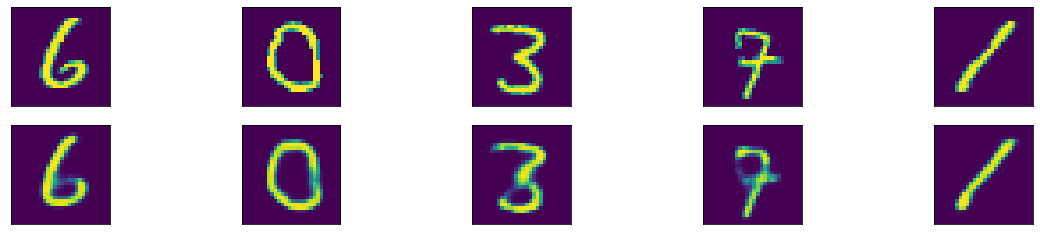

In [18]:
n = 5
data = data.numpy()
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(data[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
print(data.max(), data.min())

255.0 0.0


In [20]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)



RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().